# Kevin Nguyen
# Text-based Data Prediction Project

In [1]:
# import stuff
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from textblob import TextBlob
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from gensim import corpora
from gensim.models import LdaModel

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer

## The dataset I am using
### The dataset is a collection of about 78000 reviews on the platform Steam, for the game Palworld.
I will be analyzing the text of each review and group them by what they are talking about. This would be useful to see why the game received such positive reviews as well as where the issues are with the game.

In [ ]:
df = pd.read_csv('palworld_reviews/palworld_steam_reviews.csv', encoding='ISO-8859-1')
df[0:10]

,id,language,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,157328297,english,For an early access game this is pretty good.\...,2024-02-01 13:37:14,True,0,0,True,False,True,49,2,1069,1069,1069,2024-02-01 13:46:54
1,157328287,english,"Do not play multiplayer mode, to many hackers ...",2024-02-01 13:37:06,False,0,0,True,False,True,0,6,2693,2693,2693,2024-02-01 13:30:52
2,157328266,english,I love this game because it keeps my wife busy...,2024-02-01 13:36:44,True,0,0,True,False,True,408,15,223,223,223,2024-01-30 03:19:39
3,157328247,english,Very nice game for a fair amount of money,2024-02-01 13:36:23,True,0,0,True,False,True,65,5,1165,1165,1165,2024-02-01 13:36:18
4,157328222,english,It is pokemon. Change my mind\n\nbut honestly ...,2024-02-01 13:36:01,True,0,0,True,False,True,74,3,1254,1254,1254,2024-01-31 16:29:41
5,157328200,english,"If this avoids any legal trouble, then the dev...",2024-02-01 13:35:39,True,0,0,True,False,True,0,1,1549,1549,1549,2024-02-01 13:33:38
6,157328175,english,istg it's not pokemon similar models but nor p...,2024-02-01 13:35:09,True,0,0,True,False,True,0,3,2580,2580,2580,2024-02-01 13:45:19
7,157328098,english,THE BEST THING IVE PLAYED IN A WHILE HOURS ON ...,2024-02-01 13:33:42,True,0,0,True,False,True,0,1,3411,3411,3393,2024-02-01 13:55:25
8,157328097,english,"Amazing game, Can't stop playing it :D",2024-02-01 13:33:37,True,0,0,True,False,True,0,1,3151,3151,3151,2024-02-01 13:36:38
9,157328049,english,Today's Topic: Slavery,2024-02-01 13:32:48,True,0,0,False,False,True,0,18,1523,1523,1523,2024-02-01 13:31:08


In [48]:
df['review'][61554]

'i befriend a small chicken who immediately died to a pack of wolfs. 10/10'

 There are some empty reviews, so we remove those.

In [24]:
df.dropna(subset=['review'], inplace=True)

## Text Preprocessing
- Profanity check - after preprocessing, this is not really a problem, but something to consider for future.
- English check - even though dataset claims reviews only in english some not english, and some are just ASCII art.
- Typo check - note that there are some terms like pokemon, that get spellchecked into various words. Could mess things up.

In [39]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False
    
def spell_check(text):
    blob = TextBlob(text)
    return str(blob.correct())

In [ ]:
# spell check
df['review'] = df['review'].apply(lambda x: spell_check(x) if is_english(x) else x)

In [ ]:
#We save after spell checking since it takes hours
#df.to_csv('palworld_steam_reviews_first_Spellcheck.csv')
#df = pd.read_csv('palworld_reviews/palworld_steam_reviews_first_Spellcheck.csv', encoding='ISO-8859-1')

In [54]:
#remove non english
df = df[df['review'].apply(is_english)]

In [ ]:
#We save again after removing non english.
#The idea here is to save iteratively so we can back up to a previous step at any point.

#df.to_csv('palworld_reviews/palworld_steam_reviews_first_Spellcheck_and_nonenglish_removal.csv')
#df = pd.read_csv('palworld_reviews/palworld_steam_reviews_first_Spellcheck_and_nonenglish_removal.csv', encoding='ISO-8859-1')

We have done our spell check and removed anything non english

- Removing punctuation, stop words
- Lemmatize - we care about the meaning here, so lemmatizing is a better choice than stemming. Also, our vector/dictionary should be smaller this way.
- Tokenize text - basically putting our unique words into lists

In [184]:
import re

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess tweet text for machine learning. 
    
    Done by removing URLs and special characters, tokenizing, removing 
    stop words, and lemmatizing the words.
    """
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove "&amp;" an HTML entity
    text = re.sub(r'&amp;', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Remove word "game" - doesn't really add much since we know all the reviews will be talking about games in one way or another
    text = re.sub(r'game', '', text, flags=re.IGNORECASE)

    # For similar reasons, remove "pal" and "palworld"
    text = re.sub(r'pal', '', text, flags=re.IGNORECASE)
    text = re.sub(r'palworld', '', text, flags=re.IGNORECASE)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Initialize the lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove stop words and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(token.lower())
        for token in tokens if token.lower() not in stop_words
    ]

    return ' '.join(processed_tokens)

In [ ]:
#preprocess the text
df['processed_review'] = df['review'].apply(preprocess_text)

In [ ]:
#Just moving the column a little closer to the front
col = df.pop('processed_review')
df.insert(4,'processed_review', col)

In [ ]:
#We again save iteratively

#df.to_csv('palworld_reviews/palworld_steam_reviews_first_Spellcheck_and_nonenglish_removal_lemmatize_tokenize.csv')
#df = pd.read_csv('palworld_reviews/palworld_steam_reviews_first_Spellcheck_and_nonenglish_removal_lemmatize_tokenize.csv', encoding='ISO-8859-1')

#df.to_csv('palworld_reviews/palworld_steam_reviews_first_Spellcheck_and_nonenglish_removal_lemmatize_tokenize_remove_obvious.csv')
#df = pd.read_csv('palworld_reviews/palworld_steam_reviews_first_Spellcheck_and_nonenglish_removal_lemmatize_tokenize_remove_obvious.csv', encoding='ISO-8859-1')

After preprocessing, we find more NaN values. My thinking is that some reviews were just special chars that we ended up replacing with empty strings. Either way we drop them.

In [16]:
#probably the ascii art or some other special character only review that got made into empty
df.dropna(subset=['processed_review'], inplace=True)

## Topic modeling with LDA

We are going to split into Train and Test first (80% Train and 20% Test), and do LDA using Train.

Note: this step should probably be done before I do any kind of preprocessing, but I did not want to rerun spell check.

In [17]:
#split training - 80%, and testing - 20%
X_t, X_test = train_test_split(df, test_size=0.20, random_state=423)

In [18]:
def perform_lda(series, num_topics=3, passes=15, no_below=2, no_above=0.5, top_words=10):
    """
    Perform LDA on pieces of processed text to generate topics

    Parameters:
    - series: pandas Series containing preprocessed text.
    - num_topics: Number of topics to identify.
    - passes: Number of passes through the corpus during training.
    - no_below: Keep tokens which are contained in at least `no_below` documents.
    - no_above: Keep tokens which are contained in no more than `no_above` documents (fraction of total corpus size).

    Returns: List of of topics with their top words
    """

    texts = [text.split() for text in series]        

    dictionary = corpora.Dictionary(texts)

    dictionary.filter_extremes(no_below=no_below, no_above=no_above)

    corpus = [dictionary.doc2bow(text) for text in texts]

    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

    topics = [] 
    for i in range(num_topics):
        topics.append(lda_model.print_topic(topicno=i, topn=top_words))

    return topics, lda_model, dictionary, corpus

Perform LDA on our text to create topic labels. 7 or 8 topics looks like a good amount of topics

We do 25 passes. Take tokens that appear in at least 100 different texts, and do not take tokens that appear in more than 75% of the texts. We list the top 20 words for each topic.

In [ ]:
#perform LDA on entire training (train + val)
topics, lda_model, dictionary, corpus = perform_lda(X_t['processed_review'], num_topics=8, passes=25, no_below=100, no_above=0.75, top_words=20)    

In [222]:
topics_withID = [(topicID, topic) for topicID, topic in zip(range(len(topics)),topics)]
for topic in topics_withID:
    print(topic)

print(len(dictionary))

(0, '0.068*"good" + 0.024*"dont" + 0.017*"intend" + 0.017*"make" + 0.016*"buy" + 0.015*"people" + 0.015*"like" + 0.013*"get" + 0.012*"play" + 0.012*"actually" + 0.009*"fun" + 0.009*"take" + 0.009*"must" + 0.009*"u" + 0.008*"time" + 0.008*"better" + 0.008*"company" + 0.008*"de" + 0.008*"yes" + 0.008*"thought"')
(1, '0.073*"world" + 0.038*"survival" + 0.026*"monster" + 0.022*"play" + 0.021*"fun" + 0.017*"creature" + 0.014*"open" + 0.014*"building" + 0.013*"grafting" + 0.013*"mechanic" + 0.011*"experience" + 0.010*"design" + 0.010*"like" + 0.009*"base" + 0.009*"different" + 0.009*"unique" + 0.009*"new" + 0.008*"catching" + 0.008*"great" + 0.008*"element"')
(2, '0.044*"fun" + 0.042*"early" + 0.038*"access" + 0.020*"played" + 0.018*"bag" + 0.017*"hour" + 0.017*"ive" + 0.015*"really" + 0.015*"time" + 0.015*"lot" + 0.015*"much" + 0.014*"far" + 0.014*"worth" + 0.014*"still" + 0.013*"im" + 0.013*"good" + 0.013*"see" + 0.012*"well" + 0.011*"one" + 0.010*"even"')
(3, '0.031*"human" + 0.029*"slave

These topics look good. These are my interpretations of the words and their topics:
1. game went above expectations - people not expecting game to be as fun/good as it was
2. talking about different mechanics and design of the game - survival/(open?) world/catching monsters/building
3. talking about how good the game is despite being early access / worth the buy even in early access
4. from a quick a peek at some reviews, there are a lot of jokes about how you basically capture monsters and have them work for you - i.e. slavery, so these are those jokes I think
5. lots of reviews specifically talking about the base building aspect of the game
6. two pokemon games (scarlet/violet and legends arceus) came out around the same time palworld came out - people comparing the two games, saying palworld doing what pokemon did not?
7. reviews talking about the multiplayer aspect - good game with friends, server(issues or stable?), would recommend to friends
8. in general comparing palworld to other games like: pokemon(scarlet/violet and legends arceus), ark survival evolved, minecraft, valheim 

Assign topics to each review, adding a new column to dataframe.

In [223]:
def get_review_topic(text, model, dictionary):
    bow = dictionary.doc2bow(text.split())

    topic_distribution = model.get_document_topics(bow)

    topic = max(topic_distribution, key=lambda x: x[1])[0]

    return topic

In [ ]:
# check processed review and its topic
i = 7
print(get_review_topic(X_t['processed_review'][i], lda_model, dictionary))
print(X_t['processed_review'][i])

We label our Train data with topics

In [226]:
X_t['Topic'] = X_t['processed_review'].apply(lambda x: get_review_topic(x, lda_model, dictionary))

In [228]:
#moving the topic column closer to review
col = X_t.pop('Topic')
X_t.insert(5,'Topic', col)
X_t[0:10]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,language,Topic,processed_review,review,created,voted_up,...,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
19634,19634,19634,27694,156892297,english,2,originally thought would meme many man fun,"Originally thought this would be a meme game, ...",2024-01-26 21:13:32,True,...,0,True,False,True,0,2,2518,2518,1621,2024-01-31 04:01:22
20061,20061,20061,28299,156881532,english,4,work intend there nothing see pokemon better,"Of you work with Intend, there's nothing to se...",2024-01-26 18:28:08,True,...,0,True,False,True,0,1,967,967,424,2024-01-28 00:33:11
40404,40404,40404,55739,156558414,english,6,issue crashing start character creation starti...,I had a few issues with it crashing at the sta...,2024-01-22 16:55:38,True,...,0,True,False,True,0,1,338,338,249,2024-01-27 15:03:00
42871,42871,42871,58918,156522590,english,4,fun ton potential disconnected frequent stuck ...,Its a fun game with a ton of potential. The di...,2024-01-22 05:07:07,True,...,0,True,False,True,265,23,3657,3657,1679,2024-01-28 19:58:40
17577,17577,17577,24836,156929192,english,7,freely looklike poleon world definitely love,"Freely looklike poleon world, definitely love it",2024-01-27 08:31:52,True,...,0,True,False,True,15,4,4125,4125,3026,2024-01-31 10:23:59
32716,32716,32716,45687,156670573,english,6,great ive lost save file level annoying starti...,"Great game, but I've lost save files at level ...",2024-01-24 03:36:32,True,...,0,True,False,True,0,1,971,971,744,2024-01-24 07:33:04
25478,25478,25478,35921,156792721,english,4,currently experiencing ruining bug im map drow...,Currently experiencing a game ruining bug wher...,2024-01-25 16:50:46,True,...,0,True,False,True,0,6,4598,4598,3657,2024-01-31 02:38:07
14025,14025,14025,19788,156991257,english,6,great road fun,Great Same. Roads of fun.,2024-01-27 23:19:22,True,...,0,True,False,True,0,1,5376,5376,3964,2024-02-01 07:05:13
4082,4082,4082,5847,157225881,english,2,bit buggy early release great,bit buggy but it is early release and a great ...,2024-01-31 01:58:03,True,...,0,False,False,True,0,1,1122,1122,695,2024-02-01 07:23:00
29984,29984,29984,42058,156719120,english,2,great kind grind fun overall,"Great game, kind grind but fun overall",2024-01-24 19:10:24,True,...,0,True,False,True,0,1,1009,1009,307,2024-01-31 19:11:49


In [229]:
#create a dataframe to hold topic information - code taken from in class example
topics_df = pd.DataFrame(topics_withID, columns=['Topic ID', 'Words'])
# Convert the words in each topic to a dictionary of word frequencies
topics_df['Words'] = topics_df['Words'].apply(lambda x: dict([word.split('*') for word in x.split(' + ')]))

topics_df

,Topic ID,Words
0,0,"{'0.068': '""good""', '0.024': '""dont""', '0.017'..."
1,1,"{'0.073': '""world""', '0.038': '""survival""', '0..."
2,2,"{'0.044': '""fun""', '0.042': '""early""', '0.038'..."
3,3,"{'0.031': '""human""', '0.029': '""slavery""', '0...."
4,4,"{'0.019': '""base""', '0.016': '""get""', '0.011':..."
5,5,"{'0.066': '""pokemon""', '0.057': '""year""', '0.0..."
6,6,"{'0.053': '""love""', '0.048': '""play""', '0.043'..."
7,7,"{'0.112': '""pokemon""', '0.101': '""poleon""', '0..."


### Now that we have everything ready for neural network, we save just in case
Save a CSV of the original review, processed review, and the topic

Save the LDA model, dictionary, and corpus

Save CSV of topics and their words

In [ ]:

# Save the processed reviews and topics to a CSV file
X_t[['review', 'processed_review', 'Topic']].to_csv('palworld_reviews/reviews_with_topics.csv', index=False)
# Save the LDA model
lda_model.save('palworld_reviews/lda_model.gensim')
# Save the dictionary
dictionary.save('palworld_reviews/lda_dictionary.gensim')
# Save the corpus
corpora.MmCorpus.serialize('palworld_reviews/lda_corpus.mm', corpus)
# Save the topics DataFrame
topics_df.to_csv('palworld_reviews/topics.csv', index=False)

## Creating and training neural network

In [ ]:
X_t_DF = pd.read_csv('palworld_reviews/reviews_with_topics.csv')

In [3]:
X_t_DF.head()

,review,processed_review,Topic
0,"Originally thought this would be a meme game, ...",originally thought would meme many man fun,2
1,"Of you work with Intend, there's nothing to se...",work intend there nothing see pokemon better,4
2,I had a few issues with it crashing at the sta...,issue crashing start character creation starti...,6
3,Its a fun game with a ton of potential. The di...,fun ton potential disconnected frequent stuck ...,4
4,"Freely looklike poleon world, definitely love it",freely looklike poleon world definitely love,7


Vectorize processed text

turn our processed reviews into a large, sparse matrix with shape (number of texts, unique words)

In [4]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_t_DF['processed_review'])
# convert to array
X = X.toarray()
print(X.shape) # (number of samples, number of features)
print(len(X[0])) # input dimension

(46994, 23773)
23773


Lets split our Training into train+validation

Take our full training and split into 60% train and 20% validation, the other 20% we split above for testing set.

In [5]:
#split training into 60% train and 20% validation
X_train, X_val, Y_train, Y_val = train_test_split(X, X_t_DF['Topic'], test_size=0.20, random_state=423)

Now set up our neural network

- Our input size is the number of unique words we have 23773
- our output is the number of topics we decided on
- 4 layers: input (23773) - hidden1 (64) - hidden2 (32) - output (8)
- Dropout 20% of the neurons between hidden1-hidden2 and hidden2-output
- Use ReLU as our activation function, and cross entropy loss as loss function

In [23]:
class reviewNN(nn.Module):
    def __init__(self, input_size=23773, hidden_size1=64, hidden_size2=32, hidden_size3=32, num_classes=8):
        super(reviewNN, self).__init__()

        #Layers - input, 2 hidden, output, using ReLU as activation function
        # also try dropout to help overfitting
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU() 

        self.dropout1 = nn.Dropout(0.2)
            
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        self.dropout2 = nn.Dropout(0.2)

        # self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        # self.relu3 = nn.ReLU()

        # self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(hidden_size2, num_classes)

        #Using cross entropy loss
        self.loss_function = nn.CrossEntropyLoss()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout1(out)
        out = self.relu(out)
        # out = self.dropout1(out)
        out = self.fc2(out)
        out = self.dropout2(out)
        out = self.relu2(out)
        #out = self.dropout2(out)
        # out = self.fc3(out)
        # out = self.relu3(out)
        # out = self.dropout3(out)
        out = self.fc4(out)
        return out
    
    def loss_fn(self, y_pred, y_true):
        return self.loss_function(y_pred, y_true) 

Create model, define optimizer, and convert to tensors (after this wall of text)

**Trying to fix overfitting issues!**

list of good parameters - 2 hidden layers
 - lr 0.05, batch size 50
 - lr 0.01, batch size 50
 - lr 0.01, batch size 40
 - lr 0.001, batch size 40
 - lr 0.001, batch size 10
 - lr 0.01, batch size 10
 - lr 0.0075, batch size 10
 - ...

parameters with 3 hidden layers
 - lr 0.001, bs 32
 - lr 0.001, bs 16
 - lr 0.01, bs 16
 - ...

----------

Messing with learning rate and batch size did not help, I tried lr = 0.001, 0.005, 0.0075, 0.01, 0.05, 0.025, 0.03, with batch sizes between 10 and 50.

So then we try incorporating dropout and L2 regularization (weight_decay parameter in optimizer)

Set dropout rate = 0.2, dropout between hidden1-hidden2, hidden2-output

Getting *slightly* better results. We converge on train loss and validation loss is not shooting up like crazy, but not exactly converging as well as train loss.
 - lr 0.001, weight_decay 0.001, batch size 32, 2 hidden layers

Awesome! A weight decay of 0.005, learning rate of 0.001, batch size of 32, and 2 hidden layers finally shows validation loss dropping, albeit pretty slowly. Likewise, train loss is converging slowly, but at least it is converging. Also loss is pretty big, around 0.4

We try messing with topography on network - less neurons

------------

Our best right now seems to be:
 - learning rate = 0.025
 - weight decay = 0.005
 - 2 hidden layers, (sizes: 64, 32)
 - dropout 20% between hidden1-hidden2 and hidden2-output
 - batch size 32

We converge to ~0.5 in both training and validation. I think this is the best we will get. I am pretty sure it is because we just don't have enough data, so it's just easier to overfit.

As a side note, we import gc to collect garbage. Running this repeatedly led to some memory leakage(?)

In [24]:
import gc

In [58]:
#garbage collection
gc.collect()

9042

In [59]:
model = reviewNN()
model.train()  # Set the model to training model

optimizer = optim.Adam(model.parameters(), lr=0.0025, weight_decay=0.005)  # Adam optimizer

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)  # Convert to long tensor for CrossEntropyLoss
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(Y_val.values, dtype=torch.long)

The next bit of code is training the model, taken from example in class, of course with modified hyperparameters.

In [60]:
# Train 
num_epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

# Loss
train_loss = []
val_loss = []
# Accuracy
train_acc = [] # Do we care most about accuracy?
val_acc = []
# Recall 
train_recall = []
val_recall = []
# Precision
train_precision = []
val_precision = []


for epoch in range(num_epochs):
    # Shuffle the training data
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_true_positive = 0
    epoch_false_negative = 0
    epoch_false_positive = 0

    for i in range(num_batches):
        # Get the batch
        X_batch = X_train_tensor[i * batch_size:(i + 1) * batch_size]
        y_batch = y_train_tensor[i * batch_size:(i + 1) * batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Compute the loss
        loss = model.loss_fn(y_pred, y_batch)
        epoch_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy, recall, and precision
        _, predicted = torch.max(y_pred.data, 1)
        epoch_train_correct += (predicted == y_batch).sum().item()

        true_positive = ((predicted == y_batch) & (y_batch == 1)).sum().item()
        false_negative = ((predicted != y_batch) & (y_batch == 1)).sum().item()
        false_positive = ((predicted != y_batch) & (predicted == 1)).sum().item()

        epoch_true_positive += true_positive
        epoch_false_negative += false_negative
        epoch_false_positive += false_positive

    train_accuracy = epoch_train_correct / len(X_train_tensor)
    train_recall_value = epoch_true_positive / (epoch_true_positive + epoch_false_negative) if (epoch_true_positive + epoch_false_negative) > 0 else 0
    train_precision_value = epoch_true_positive / (epoch_true_positive + epoch_false_positive) if (epoch_true_positive + epoch_false_positive) > 0 else 0

    train_loss.append(epoch_train_loss / num_batches)
    train_acc.append(train_accuracy)
    train_recall.append(train_recall_value)
    train_precision.append(train_precision_value)

    # Validation
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        val_pred = model(X_val_tensor)
        val_loss_value = model.loss_fn(val_pred, y_val_tensor)

        # Calculate validation accuracy
        _, predicted = torch.max(val_pred.data, 1)
        correct = (predicted == y_val_tensor).sum().item()
        val_accuracy = correct / len(y_val_tensor)

        # Calculate validation recall and precision
        true_positive = ((predicted == y_val_tensor) & (y_val_tensor == 1)).sum().item()
        false_negative = ((predicted != y_val_tensor) & (y_val_tensor == 1)).sum().item()
        false_positive = ((predicted != y_val_tensor) & (predicted == 1)).sum().item()

        val_recall_value = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        val_precision_value = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

        val_loss.append(val_loss_value.item())
        val_acc.append(val_accuracy)
        val_recall.append(val_recall_value)
        val_precision.append(val_precision_value)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, '
          f'Train Recall: {train_recall[-1]:.4f}, Train Precision: {train_precision[-1]:.4f}, '
          f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}, '
          f'Val Recall: {val_recall[-1]:.4f}, Val Precision: {val_precision[-1]:.4f}')

Epoch [1/30], Train Loss: 1.1255, Train Accuracy: 0.6128, Train Recall: 0.4305, Train Precision: 0.6647, Val Loss: 0.8158, Val Accuracy: 0.7417, Val Recall: 0.7754, Val Precision: 0.7016
Epoch [2/30], Train Loss: 0.7189, Train Accuracy: 0.7637, Train Recall: 0.6653, Train Precision: 0.7606, Val Loss: 0.6935, Val Accuracy: 0.7755, Val Recall: 0.7307, Val Precision: 0.7019
Epoch [3/30], Train Loss: 0.6443, Train Accuracy: 0.7893, Train Recall: 0.6742, Train Precision: 0.7807, Val Loss: 0.6372, Val Accuracy: 0.7892, Val Recall: 0.6425, Val Precision: 0.7666
Epoch [4/30], Train Loss: 0.6076, Train Accuracy: 0.7993, Train Recall: 0.6887, Train Precision: 0.7879, Val Loss: 0.6238, Val Accuracy: 0.7934, Val Recall: 0.7778, Val Precision: 0.7302
Epoch [5/30], Train Loss: 0.5807, Train Accuracy: 0.8098, Train Recall: 0.7101, Train Precision: 0.7941, Val Loss: 0.5792, Val Accuracy: 0.8103, Val Recall: 0.7452, Val Precision: 0.7951
Epoch [6/30], Train Loss: 0.5602, Train Accuracy: 0.8170, Train R

## Results
### We plot the training and validation loss to evaluate our model.

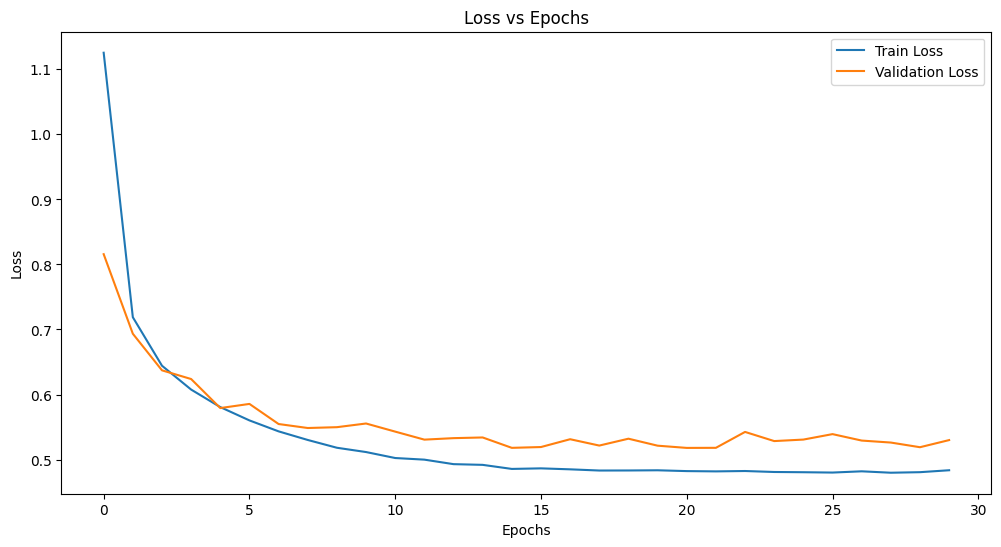

In [62]:
# Plot the validation and training loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Looks okay. We get convergence to about 0.5, so loss isn't so bad(?). 

Difference in loss is pretty small, about 0.04. 

Also accuracy, recall, precision are pretty good, at around 0.8

## Using model on our testing set

We take our testing set - which already has processed reviews - and vectorize it like the training set using the vectorizer we have already declared
- note that the testing set may have some new words, but since we use the same vectorizer those words will be dropped

In [63]:
X_testing = vectorizer.transform(X_test['processed_review'])
# convert to array
X_testing = X_testing.toarray()
print(X_testing.shape) # (number of samples, number of features)
print(len(X_testing[0])) # input dimension
X_test[0:3]

(11749, 23773)
23773


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,language,processed_review,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
29665,29665,29665,41628,156725016,english,making poleon go one,we making it out of poleon go with this one,2024-01-24 20:42:55,True,1,0,True,False,True,0,3,6740,6740,2943,2024-02-01 12:27:46
14644,14644,14644,20666,156982095,english,made intend would never make think funny,They made a game that Intend would never make ...,2024-01-27 21:03:24,True,0,0,False,True,True,221,15,1266,1266,1091,2024-01-28 14:28:53
52287,52287,52287,70731,156389507,english,okay see lot people comparing ark poleon toget...,"Okay, so I see a lot of people comparing this ...",2024-01-20 17:21:18,True,0,0,False,False,True,0,12,6852,6852,169,2024-02-01 10:09:30


In [64]:
#Convert to tensor
X_testing_tensor = torch.tensor(X_testing, dtype=torch.float32)

Set up our model to evaluate and classify our testing set.
- the model outputs probabilities (logits?) - we will apply softmax on them to get a probability distribution to make these a little easier to interpret

In [78]:
model.eval()
with torch.no_grad():
    labeling = model(X_testing_tensor)

In [97]:
i = 2146
print(labeling)
print(labeling[i])

tensor([[ 0.6539, -0.9085, -0.5522,  ..., -1.3611, -2.1366,  1.8640],
        [ 6.7742, -1.8987, -0.9005,  ...,  0.7360, -2.3763, -1.6121],
        [-1.2436,  1.4910,  4.6266,  ..., -4.0563, -3.3932,  0.2101],
        ...,
        [-1.2677,  5.8262, -0.4450,  ..., -2.4687, -1.9545, -2.5291],
        [ 2.4358, -1.2213,  0.2420,  ..., -1.0331, -1.3122, -0.3110],
        [ 0.9600,  0.0664, -1.0918,  ..., -0.8029,  2.2411, -0.0566]])
tensor([-1.0376,  5.2117,  3.3902, -1.0077, -0.4828, -2.8368, -1.7945, -1.4134])


In [98]:
labeling_probs = torch.softmax(labeling, dim=1)
print(labeling_probs)
print(labeling_probs[i])

tensor([[1.1342e-01, 2.3775e-02, 3.3954e-02,  ..., 1.5121e-02, 6.9630e-03,
         3.8038e-01],
        [9.9321e-01, 1.6999e-04, 4.6127e-04,  ..., 2.3694e-03, 1.0544e-04,
         2.2642e-04],
        [4.5879e-04, 7.0671e-03, 1.6257e-01,  ..., 2.7547e-05, 5.3466e-05,
         1.9632e-03],
        ...,
        [6.5411e-04, 7.8796e-01, 1.4893e-03,  ..., 1.9683e-04, 3.2915e-04,
         1.8529e-04],
        [5.3170e-01, 1.3722e-02, 5.9280e-02,  ..., 1.6563e-02, 1.2529e-02,
         3.4099e-02],
        [1.6368e-01, 6.6974e-02, 2.1033e-02,  ..., 2.8078e-02, 5.8934e-01,
         5.9221e-02]])
tensor([1.6488e-03, 8.5352e-01, 1.3808e-01, 1.6988e-03, 2.8716e-03, 2.7276e-04,
        7.7351e-04, 1.1323e-03])


In [99]:
pred_labels = torch.argmax(labeling_probs, dim=1)
print(pred_labels)
print(pred_labels[i])

tensor([7, 0, 4,  ..., 1, 0, 6])
tensor(1)


In [100]:
X_test[i:i+1]['processed_review']

5194    definitely flowed early access fun take best e...
Name: processed_review, dtype: object

Now we can apply our predicted labels to our testing set!

In [102]:
pred_labels_df = pd.DataFrame(pred_labels)
pred_labels_df

,0
0,7
1,0
2,4
3,2
4,6
...,...
11744,6
11745,6
11746,1
11747,0


In [ ]:
X_test['predicted_label'] = pred_labels_df.values

In [109]:
col = X_test.pop('predicted_label')
X_test.insert(7,'predicted_label', col)

Let's take a random sample of 10 reviews and see how we did. Repeat this 5 times.

Counts:
- Good: 23
- Not good or bad / hard to tell: 9
- Bad: 8

I counted a labeling as good if after reading the processed review:
- I have an idea of what the review is about
- and if the labeling makes sense compared to my own prediction, and the words present

I counted as somewhere in the middle if:
- the review had too few words to get any kind of idea of topic
- or words were too incoherent
- or if I could tell the labeling was focused on a specific word and labeled it slightly wrong

I counted a bad if:
- predicted topic was off from my own guess and the actual words present

Of course **I am biased**!!! But will do my best to be fair.

In [128]:
test_sample = X_test.sample(n=10)

In [129]:
for index, row in test_sample.iterrows():
    print(row['processed_review'])
    print(row['predicted_label'])
    print("---------------")

bag still best ive played long time
2
---------------
fantastic simple adorable adjective violates many human right recommend anyone
1
---------------
quite nice cool also
1
---------------
sortof recommend good hardware requirement insane yet see anything make understand need much computer like cyberpunk older king maybe thatll change late
4
---------------
nothing satisfying capturing animal human work forcing fight kind kind heaven
3
---------------
really good guy
0
---------------
kind like valheim gun poleon
7
---------------
everyone world exciting fun ever since pokemon day think pokemon ark baby world solved pokemon need highly missing despite early access still quite bit rug issue understandable early access project world engaging interactive pokemon actually move creature use mount weapon using ability using protectionshield kill need food note survival monster naming even better watching run pokemon still catch combat hard monster attacking trying catch unique join workforc

Separate count for last sample above (40-50) - listing off in order they appear
- hard to tell
- bad
- bad (hard to tell?)
- bad
- good
- good(?)
- good
- good
- good
- hard to tell

## It seems maybe our model is not very good! See slides for ideas for the future.